In [1]:
# basic libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
# selection of specific features
mol_df = pd.read_csv('../../../data/her_molecules.csv')
mol_df = mol_df[['name','smiles','pIC50','activity']]
print(f'DataFrame shape: {mol_df.shape}')
mol_df.head(2)

DataFrame shape: (2593, 4)


,name,smiles,pIC50,activity
0,CHEMBL477,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,15.204120,low
1,CHEMBL433520,CCN(CC)CC(O)CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,15.041393,low


###### Standardization of  molecules

In [4]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs

In [5]:
def standardize(smiles):
    
    # create kdkit mol object
    mol = [Chem.MolFromSmiles(x) for x in smiles]
    # salt removal 
    largest_frag = [rdMolStandardize.LargestFragmentChooser().choose(x) for x in mol]
    # normalization to correct functional groups
    normal = [rdMolStandardize.Normalizer().normalize(x) for x in largest_frag]
    # uncharger
    uncharged = [rdMolStandardize.Uncharger().uncharge(x) for x in normal]
    # reionise
    reioned = [rdMolStandardize.Reionizer().reionize(x) for x in uncharged]
    # neutralize the mol
    neutral = [rdMolStandardize.Uncharger().uncharge(x) for x in reioned]
    # tautomer enumeration
    clean_mol = [rdMolStandardize.TautomerEnumerator().Canonicalize(x) for x in tqdm(neutral)]
    
    return clean_mol

In [6]:
block = BlockLogs()
mols = standardize(mol_df['smiles'])
del block

100%|███████████████████████████████████████████████████████████| 2593/2593 [01:32<00:00, 27.94it/s]


In [11]:
mol_df['mols'] = mols
print(f'Shape of the dataset: {mol_df.shape}')
mol_df.head(2)

Shape of the dataset: (2593, 5)


,name,smiles,pIC50,activity,mols
0,CHEMBL477,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,15.204120,low,<rdkit.Chem.rdchem.Mol object at 0x7f0bfed64c40>
1,CHEMBL433520,CCN(CC)CC(O)CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,15.041393,low,<rdkit.Chem.rdchem.Mol object at 0x7f0bfed64d60>


In [12]:
# save
mol_df.to_csv('../../../data/clean_her_molecules.csv', index=False)

In [7]:
# viewing of molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

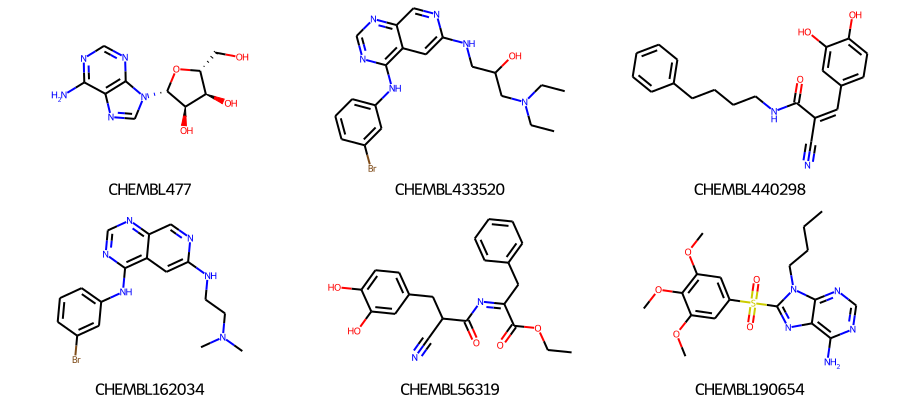

In [8]:
Draw.MolsToGridImage(
    mol_df['mols'][:6].tolist(), 
    legends= mol_df['name'].tolist(),
    subImgSize=(300, 200), 
    useSVG=True
    )

###### Substructuture filter (PAINS)

In [9]:
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [10]:
# initializing the filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# search for bad substructures
bad_mols = []
clean_mols = []
for index, row in tqdm(mol_df.iterrows(), total=mol_df['smiles'].shape[0]):
    mols = Chem.MolFromSmiles(row.smiles)
    # Get the first matching substructures
    entry = catalog.GetFirstMatch(mols)  
    if entry is not None:
        # store substrucure information
        bad_mols.append(
            {
                "names": row.name,
                "mols": mols,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without bad substructures
        clean_mols.append(index)

bad_mols = pd.DataFrame(bad_mols)
# keep molecules without PAINS
mol_df = mol_df.loc[clean_mols]  

100%|██████████████████████████████████████████████████████████| 2596/2596 [00:14<00:00, 173.65it/s]


In [11]:
print(f"Number of molecules with problematic substructures: {len(bad_mols)}")
print(f"Number of molecules without problematic substructures: {len(mol_df)}")

Number of molecules with problematic substructures: 211
Number of molecules without problematic substructures: 2385


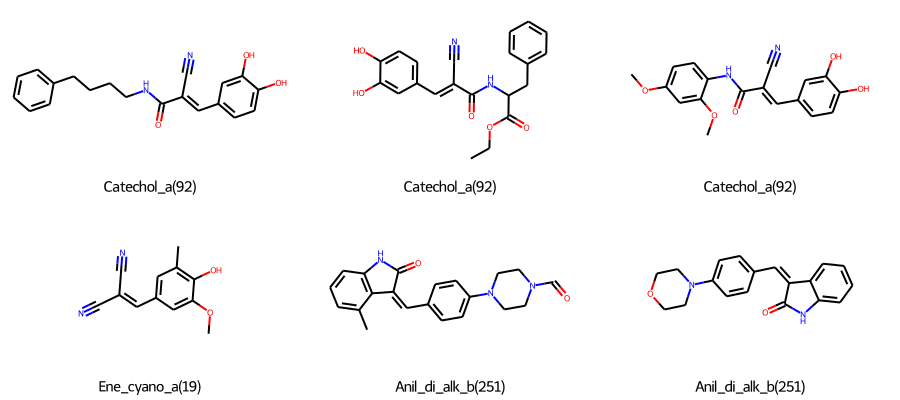

In [12]:
# Looking at some molecules with problematic substructures

Draw.MolsToGridImage(
    bad_mols['mols'][:6], 
    legends= bad_mols['pains'].tolist()[:6],
    subImgSize=(300, 200), 
    useSVG=True
    )

###### All descriptors

In [13]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [14]:
def descriptors(mol):
    """
    calcualte all 208 descriptors
    """
    descs = []
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])        
    header = calc.GetDescriptorNames()
    descs = [calc.CalcDescriptors(x) for x in tqdm(mol)]
    descs = pd.DataFrame(descs, columns=header)
    return descs

In [15]:
all_desc_df = descriptors(mol_df['mols'])
print(f'Shape of the dataset: {all_desc_df.shape}')
all_desc_df.head(2)

100%|███████████████████████████████████████████████████████████| 2385/2385 [01:08<00:00, 35.03it/s]


Shape of the dataset: (2385, 208)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.950184,-1.18913,9.950184,0.218049,0.490520,267.245,254.141,267.096754,102,0,...,0,0,0,0,0,0,0,0,0,0
1,10.258404,-0.46881,10.258404,0.427670,0.463708,445.365,420.165,444.127322,148,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# check for missing values
np.isnan(all_desc_df).sum().sort_values(ascending=False)

MaxEStateIndex    0
MinEStateIndex    0
fr_COO2           0
fr_C_O            0
fr_C_O_noCOO      0
                 ..
SlogP_VSA12       0
SlogP_VSA2        0
SlogP_VSA3        0
SlogP_VSA4        0
fr_urea           0
Length: 208, dtype: int64

In [17]:
# check for infinite values
np.isinf(all_desc_df).sum().sort_values(ascending=False)

MaxEStateIndex    0
MinEStateIndex    0
fr_COO2           0
fr_C_O            0
fr_C_O_noCOO      0
                 ..
SlogP_VSA12       0
SlogP_VSA2        0
SlogP_VSA3        0
SlogP_VSA4        0
fr_urea           0
Length: 208, dtype: int64

###### Lipinski descriptors

In [19]:
# selection of few descriptors
lipi_desc_df = descriptors(mol_df['mols'])
lipi_desc_df = lipi_desc_df[['MolWt', 'MolLogP', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds']]
print(f'Shape of the dataset: {lipi_desc_df.shape}')
lipi_desc_df.head(2)

100%|███████████████████████████████████████████████████████████| 2385/2385 [00:46<00:00, 50.84it/s]


Shape of the dataset: (2385, 5)


,MolWt,MolLogP,NumHAcceptors,NumHDonors,NumRotatableBonds
0,267.245,-1.9800,9,4,2
1,445.365,3.6455,7,3,9


In [20]:
# check for missing values
np.isnan(lipi_desc_df).sum().sort_values(ascending=False)

MolWt                0
MolLogP              0
NumHAcceptors        0
NumHDonors           0
NumRotatableBonds    0
dtype: int64

In [21]:
# check for missing values
np.isnan(lipi_desc_df).sum().sort_values(ascending=False)

MolWt                0
MolLogP              0
NumHAcceptors        0
NumHDonors           0
NumRotatableBonds    0
dtype: int64

###### Molecular Fingerprints Calculations

In [22]:
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem.EState import Fingerprinter

In [23]:
def generate_fps(mol_list, method,radius=2, n_bits=2048):
    """
    input: list of molecules and type of fingerprint
    output: array of fingerprints
    """
    if method == "MACCSKeys":
        fps = []
        for mol in tqdm(mol_list):
            fp = np.array(MACCSkeys.GenMACCSKeys(mol))
            fps.append(fp)
        return fps
    elif method == "Morgan":
        fps = []
        for mol in tqdm(mol_list):
            fp = np.array(GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits))
            fps.append(fp)
        return fps
    elif method == "Avalon":
        fps = []
        for mol in tqdm(mol_list):
            fp = np.array(GetAvalonFP(mol))
            fps.append(fp)
        return fps
    elif method == "Estate":
        fps = []
        for mol in tqdm(mol_list):
            fp = Fingerprinter.FingerprintMol(mol)[0]
            fps.append(fp)
        return fps
    else:
        raise TypeError(f"Wrong method specified: {method}")

###### Feature Encoding

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
label_encoder = LabelEncoder()

#encode y variable to numerical variable
label_encoder.fit(mol_df['activity'])

# encode y to catergorical varible
classes = label_encoder.classes_
classes

array(['high', 'low', 'medium'], dtype=object)

###### Machine Learning Model Pipeline

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

In [27]:
# mechnine learning pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

model_pipeline = []
model_pipeline.append(SVC(probability=True))
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

In [28]:
%%time

for method in ["All Descriptors", "Lipinski Descriptors", "MACCSKeys", "Morgan", "Avalon", "Estate"]:
    if method == "Lipinski Descriptors":
        feature = lipi_desc_df
    elif method == "All Descriptors":
        feature = all_desc_df
    else:
        feature = generate_fps(mol_df['mols'], method)
    
    # features and target
    X = np.array(feature)
    y = np.array(mol_df['activity'])

    # metrices
    accu_train = []
    accu_test = []

    auc_train = []
    auc_test = []

    # kf object
    kf = StratifiedKFold(n_splits=10)

    # k fold loop
    for train_index, test_index in kf.split(X,y):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

    for model in model_pipeline:
        model.fit(X_train, y_train)

        # metrics
        accu_train.append(accuracy_score(y_train, model.predict(X_train)))
        accu_test.append(accuracy_score(y_test, model.predict(X_test)))

        auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr'))
        auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'))

        print(f"Feature Type: {method} + {model}")
        print(f'Train set accuracy score: {np.mean(accu_train):.3f}')
        print(f'Test set accuracy score: {np.mean(accu_test):.3f}')
        print()
        print(f'Train set ROC AUC score: {np.mean(auc_train):.3f}')
        print(f'Test set ROC AUC score: {np.mean(auc_test):.3f}')
        print("-"*60,"\n")

Feature Type: All Descriptors + SVC(probability=True)
Train set accuracy score: 0.420
Test set accuracy score: 0.420

Train set ROC AUC score: 0.507
Test set ROC AUC score: 0.535
------------------------------------------------------------ 

Feature Type: All Descriptors + KNeighborsClassifier()
Train set accuracy score: 0.552
Test set accuracy score: 0.471

Train set ROC AUC score: 0.683
Test set ROC AUC score: 0.590
------------------------------------------------------------ 

Feature Type: All Descriptors + DecisionTreeClassifier()
Train set accuracy score: 0.699
Test set accuracy score: 0.517

Train set ROC AUC score: 0.789
Test set ROC AUC score: 0.623
------------------------------------------------------------ 

Feature Type: All Descriptors + RandomForestClassifier()
Train set accuracy score: 0.772
Test set accuracy score: 0.571

Train set ROC AUC score: 0.842
Test set ROC AUC score: 0.678
------------------------------------------------------------ 

Feature Type: All Descrip

100%|██████████████████████████████████████████████████████████| 2385/2385 [00:03<00:00, 603.90it/s]


Feature Type: MACCSKeys + SVC(probability=True)
Train set accuracy score: 0.783
Test set accuracy score: 0.727

Train set ROC AUC score: 0.919
Test set ROC AUC score: 0.832
------------------------------------------------------------ 

Feature Type: MACCSKeys + KNeighborsClassifier()
Train set accuracy score: 0.791
Test set accuracy score: 0.666

Train set ROC AUC score: 0.929
Test set ROC AUC score: 0.797
------------------------------------------------------------ 

Feature Type: MACCSKeys + DecisionTreeClassifier()
Train set accuracy score: 0.850
Test set accuracy score: 0.648

Train set ROC AUC score: 0.952
Test set ROC AUC score: 0.762
------------------------------------------------------------ 

Feature Type: MACCSKeys + RandomForestClassifier()
Train set accuracy score: 0.880
Test set accuracy score: 0.667

Train set ROC AUC score: 0.964
Test set ROC AUC score: 0.786
------------------------------------------------------------ 

Feature Type: MACCSKeys + GaussianNB()
Train set 

100%|██████████████████████████████████████████████████████████| 2385/2385 [00:03<00:00, 764.80it/s]


Feature Type: Morgan + SVC(probability=True)
Train set accuracy score: 0.851
Test set accuracy score: 0.723

Train set ROC AUC score: 0.970
Test set ROC AUC score: 0.857
------------------------------------------------------------ 

Feature Type: Morgan + KNeighborsClassifier()
Train set accuracy score: 0.844
Test set accuracy score: 0.687

Train set ROC AUC score: 0.962
Test set ROC AUC score: 0.824
------------------------------------------------------------ 

Feature Type: Morgan + DecisionTreeClassifier()
Train set accuracy score: 0.892
Test set accuracy score: 0.709

Train set ROC AUC score: 0.975
Test set ROC AUC score: 0.810
------------------------------------------------------------ 

Feature Type: Morgan + RandomForestClassifier()
Train set accuracy score: 0.917
Test set accuracy score: 0.716

Train set ROC AUC score: 0.981
Test set ROC AUC score: 0.824
------------------------------------------------------------ 

Feature Type: Morgan + GaussianNB()
Train set accuracy score:

100%|██████████████████████████████████████████████████████████| 2385/2385 [00:04<00:00, 545.15it/s]


Feature Type: Avalon + SVC(probability=True)
Train set accuracy score: 0.820
Test set accuracy score: 0.706

Train set ROC AUC score: 0.949
Test set ROC AUC score: 0.837
------------------------------------------------------------ 

Feature Type: Avalon + KNeighborsClassifier()
Train set accuracy score: 0.817
Test set accuracy score: 0.651

Train set ROC AUC score: 0.947
Test set ROC AUC score: 0.809
------------------------------------------------------------ 

Feature Type: Avalon + DecisionTreeClassifier()
Train set accuracy score: 0.875
Test set accuracy score: 0.632

Train set ROC AUC score: 0.964
Test set ROC AUC score: 0.758
------------------------------------------------------------ 

Feature Type: Avalon + RandomForestClassifier()
Train set accuracy score: 0.903
Test set accuracy score: 0.657

Train set ROC AUC score: 0.973
Test set ROC AUC score: 0.776
------------------------------------------------------------ 

Feature Type: Avalon + GaussianNB()
Train set accuracy score:

100%|██████████████████████████████████████████████████████████| 2385/2385 [00:04<00:00, 586.24it/s]


Feature Type: Estate + SVC(probability=True)
Train set accuracy score: 0.680
Test set accuracy score: 0.588

Train set ROC AUC score: 0.834
Test set ROC AUC score: 0.737
------------------------------------------------------------ 

Feature Type: Estate + KNeighborsClassifier()
Train set accuracy score: 0.742
Test set accuracy score: 0.597

Train set ROC AUC score: 0.889
Test set ROC AUC score: 0.747
------------------------------------------------------------ 

Feature Type: Estate + DecisionTreeClassifier()
Train set accuracy score: 0.818
Test set accuracy score: 0.602

Train set ROC AUC score: 0.926
Test set ROC AUC score: 0.730
------------------------------------------------------------ 

Feature Type: Estate + RandomForestClassifier()
Train set accuracy score: 0.856
Test set accuracy score: 0.625

Train set ROC AUC score: 0.944
Test set ROC AUC score: 0.747
------------------------------------------------------------ 

Feature Type: Estate + GaussianNB()
Train set accuracy score:

In [29]:
# The best combination = Feature Type: Morgan + RandomForestClassifier()

###### Hyperparameter Optimization

In [30]:
import optuna
print("Optuna Version : {}".format(optuna.__version__))

Optuna Version : 3.0.0


In [31]:
# hyperparameter optimization using Morgan fingerptints and RandomForestClassifier

In [32]:
# define the function used to evaluate a given configuration
def objective(trial):
    
    feature = generate_fps(mol_df['mols'], "Morgan")
    X = np.array(feature)
    y = np.array(mol_df['activity'])
    
    
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'max_features':trial.suggest_categorical("max_features", ['auto', 'sqrt','log2',None]),
        'max_depth': trial.suggest_int("max_depth", 1, 10 ),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 2, ),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 3, ),
        "criterion":trial.suggest_categorical("criterion", [ 'gini', 'entropy']),
    }

    # kf object
    kf = StratifiedKFold(n_splits=10,
                         shuffle=True,
                        random_state=42)

    # create model
    model = RandomForestClassifier(random_state=42,
                                   **params)

    # k fold loop
    for train_index, test_index in kf.split(X,y):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        # model
        model.fit(X_train, y_train)

        # metrics
        accu_test = (accuracy_score(y_test, model.predict(X_test)))
        accu_train = (accuracy_score(y_train, model.predict(X_train)))

        # convert from a maximizing score to a minimizing score
        return -accu_test

In [33]:
%%time

study = optuna.create_study(direction="minimize", study_name="Minimize Function")
study.optimize(objective, n_trials=15)

[I 2022-09-11 20:04:33,862] A new study created in memory with name: Minimize Function
100%|██████████████████████████████████████████████████████████| 2385/2385 [00:03<00:00, 656.00it/s]
[I 2022-09-11 20:04:41,537] Trial 0 finished with value: -0.6736401673640168 and parameters: {'n_estimators': 906, 'max_features': 'auto', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: -0.6736401673640168.
100%|██████████████████████████████████████████████████████████| 2385/2385 [00:03<00:00, 682.70it/s]
[I 2022-09-11 20:04:51,563] Trial 1 finished with value: -0.7112970711297071 and parameters: {'n_estimators': 911, 'max_features': 'auto', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 3, 'criterion': 'gini'}. Best is trial 1 with value: -0.7112970711297071.
100%|██████████████████████████████████████████████████████████| 2385/2385 [00:03<00:00, 670.33it/s]
[I 2022-09-11 20:04:56,039] Trial 2 finished with value: -0.6

CPU times: user 7min 20s, sys: 667 ms, total: 7min 21s
Wall time: 7min 20s


In [34]:
trial = study.best_trial
print(f"Accuracy: {(trial.value):.3f}")
print(f"Best hyperparameters: {(trial.params)}")

Accuracy: -0.778
Best hyperparameters: {'n_estimators': 967, 'max_features': None, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'entropy'}


In [35]:
# improvement of Test set accuracy score from 0.704 to 0.778

###### Model avaluation using best parameters

In [36]:
from sklearn.preprocessing import StandardScaler

In [53]:
feature = generate_fps(mol_df['mols'], "Morgan")

100%|██████████████████████████████████████████████████████████| 2385/2385 [00:03<00:00, 751.72it/s]


In [55]:
%%time

X = np.array(feature)
y = np.array(mol_df['activity'])

# metrices
accu_train = []
accu_test = []

auc_train = []
auc_test = []

# feature standardization
scaler = StandardScaler()

# kf object
kf = StratifiedKFold(n_splits=10,
                     shuffle=True,
                    random_state=42)

# create model
model = RandomForestClassifier(**study.best_params,
                                random_state=42)

# k fold loop
for train_index, test_index in kf.split(X,y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    # scaler
    scaler.fit(X_train)

    # feature standardization
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # model
    model.fit(X_train, y_train)

    # metrics
    accu_train.append(accuracy_score(y_train, model.predict(X_train)))
    accu_test.append(accuracy_score(y_test, model.predict(X_test)))

    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr'))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'))

print(f'Train set accuracy score: {np.mean(accu_train):.3f}')
print(f'Test set accuracy score: {np.mean(accu_test):.3f}')
print()
print(f'Train set ROC AUC score: {np.mean(auc_train):.3f}')
print(f'Test set ROC AUC score: {np.mean(auc_test):.3f}')
print()

Train set accuracy score: 0.828
Test set accuracy score: 0.748

Train set ROC AUC score: 0.955
Test set ROC AUC score: 0.883
CPU times: user 17min 17s, sys: 503 ms, total: 17min 17s
Wall time: 17min 17s


In [48]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
plt.rcdefaults()

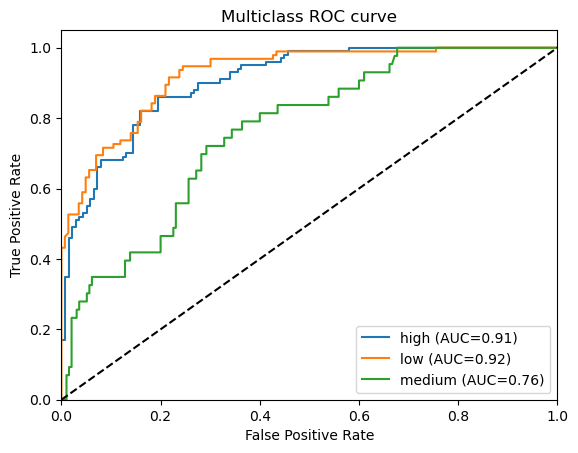

In [49]:
# ROC curve plot

# binarize the y_values
y_test_binarized = label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]
for i in range(n_class):
    #  Compute fpr, tpr, thresholds and roc auc
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], model.predict_proba(X_test)[:,i]) 
    # compute AUC score
    roc_auc[i] = auc(fpr[i], tpr[i])
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='-', label='%s (AUC=%0.2f)'%(classes[i],roc_auc[i])) 

plt.rcParams["figure.figsize"] = [6, 5]
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

######  Predictions

In [50]:
mol_index = []
for i, v in enumerate(y_test):
    if v == "low":    
        mol_index.append(i)
        
test_indx = mol_index[5] 
test_indx

5

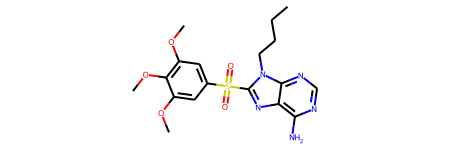

In [51]:
mol_df['mols'][test_indx]

In [52]:
model.predict([X_test[test_indx]])

array(['low'], dtype=object)